<a href="https://colab.research.google.com/github/ElhaliAmina/Deep_Learning_Tp1_ANN/blob/main/DL_RNN_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Text classification with an RNN**

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

Import matplotlib and create a helper function to plot graphs:

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

**Setup input pipeline**

The IMDB large movie review dataset is a binary classification dataset—all the reviews have either a positive or negative sentiment.

Download the dataset using TFDS.


In [ ]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteB8KX0S/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteB8KX0S/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteB8KX0S/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


The dataset info includes the encoder (a tfds.features.text.SubwordTextEncoder).

In [ ]:
encoder = info.features['text'].encoder

In [ ]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


This text encoder will reversibly encode any string, falling back to byte-encoding if necessary.

In [ ]:
sample_string = 'Hi TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

Encoded string is [1052, 7961, 6307, 2327, 4043, 2120, 7975]


In [ ]:
original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

The original string: "Hi TensorFlow."


In [ ]:
assert original_string == sample_string

In [ ]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

1052 ----> Hi
7961 ---->  
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


Prepare the data for training

Next create batches of these encoded strings. Use the padded_batch method to zero-pad the sequences to the length of the longest string in the batch:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

**Create the model**

Build a tf.keras.Sequential model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a tf.keras.layers.Dense layer.

A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input—and then to the next.

The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the output. This helps the RNN to learn long range dependencies.


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Compile the Keras model to configure the training process:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Train the model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 44s 112ms/step - loss: 0.6788 - accuracy: 0.5118 - val_loss: 0.5472 - val_accuracy: 0.7354
Epoch 2/10
391/391 [==============================] - 43s 111ms/step - loss: 0.3861 - accuracy: 0.8353 - val_loss: 0.3546 - val_accuracy: 0.8536
Epoch 3/10
391/391 [==============================] - 44s 111ms/step - loss: 0.2706 - accuracy: 0.8940 - val_loss: 0.4340 - val_accuracy: 0.8469
Epoch 4/10
391/391 [==============================] - 43s 111ms/step - loss: 0.2209 - accuracy: 0.9184 - val_loss: 0.3713 - val_accuracy: 0.8552
Epoch 5/10
391/391 [==============================] - 43s 110ms/step - loss: 0.1924 - accuracy: 0.9302 - val_loss: 0.3628 - val_accuracy: 0.8630
Epoch 6/10
391/391 [==============================] - 43s 110ms/step - loss: 0.1762 - accuracy: 0.9370 - val_loss: 0.3552 - val_accuracy: 0.8677
Epoch 7/10
391/391 [==============================] - 42s 109ms/step - loss: 0.1565 - accuracy: 0.9454 - val_loss: 0.4189 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 18s 47ms/step - loss: 0.3860 - accuracy: 0.8544
Test Loss: 0.38600772619247437
Test Accuracy: 0.8543999791145325


The above model does not mask the padding applied to the sequences. This can lead to skew if trained on padded sequences and test on un-padded sequences. Ideally you would use masking to avoid this, but as you can see below it only have a small effect on the output.

If the prediction is >= 0.5, it is positive else it is negative.


In [ ]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [ ]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [ ]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.05020119]]


In [ ]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.41845462]]


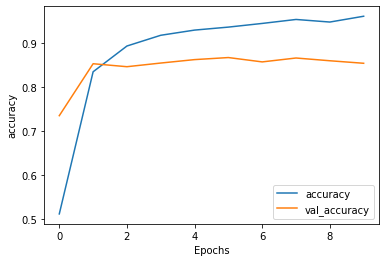

In [ ]:
plot_graphs(history, 'accuracy')

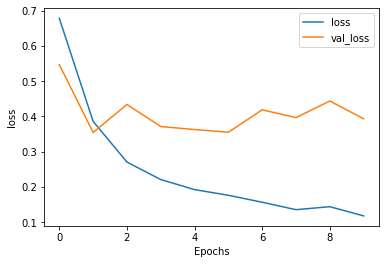

In [ ]:
plot_graphs(history, 'loss')

**Stack two or more LSTM layers**

Keras recurrent layers have two available modes that are controlled by the return_sequences constructor argument:

Return either the full sequences of successive outputs for each timestep (a 3D tensor of shape (batch_size, timesteps, output_features)).
Return only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)).

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 74s 190ms/step - loss: 0.6618 - accuracy: 0.5428 - val_loss: 0.4995 - val_accuracy: 0.7755
Epoch 2/10
391/391 [==============================] - 73s 188ms/step - loss: 0.4404 - accuracy: 0.8069 - val_loss: 0.4215 - val_accuracy: 0.8214
Epoch 3/10
391/391 [==============================] - 73s 188ms/step - loss: 0.3232 - accuracy: 0.8743 - val_loss: 0.3620 - val_accuracy: 0.8568
Epoch 4/10
391/391 [==============================] - 74s 190ms/step - loss: 0.2663 - accuracy: 0.9050 - val_loss: 0.3677 - val_accuracy: 0.8354
Epoch 5/10
391/391 [==============================] - 74s 189ms/step - loss: 0.2131 - accuracy: 0.9304 - val_loss: 0.3690 - val_accuracy: 0.8552
Epoch 6/10
391/391 [==============================] - 73s 188ms/step - loss: 0.1842 - accuracy: 0.9428 - val_loss: 0.3703 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 74s 188ms/step - loss: 0.1575 - accuracy: 0.9542 - val_loss: 0.4261 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 34s 86ms/step - loss: 0.5137 - accuracy: 0.8472
Test Loss: 0.5137302875518799
Test Accuracy: 0.8472399711608887


In [ ]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-2.457225]]


In [ ]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-4.111402]]


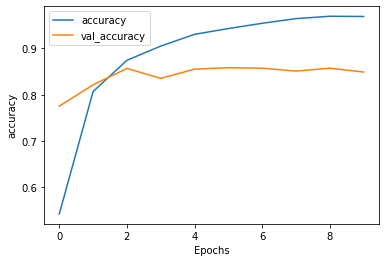

In [ ]:
plot_graphs(history, 'accuracy')

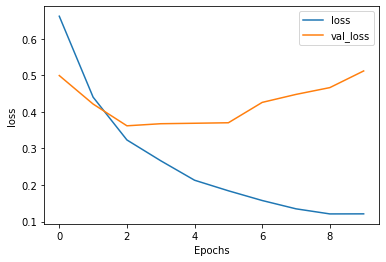

In [ ]:
plot_graphs(history, 'loss')